In [1]:
from DataPreprocessing.python.Data import *

import pandas as pd
import numpy as np


## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

In [2]:
rootData = Data("/Users/czkaiweb/Research/ErdosBootCamp/Project/ProjectData/Root_Insurance_data.csv")
rootData.loadData()
rootData.factorizeData()
rootData.splitData(fraction=[0.5,0.3,0.2],random_seed=42)
data_train = rootData.getTrainDataCopy()
data_validation = rootData.getValidationDataCopy()
data_test  = rootData.getTestDataCopy()

In [3]:
from xgboost import XGBRegressor

In [4]:
X_train = data_train.iloc[:, 0:4].values
y_train = data_train.iloc[:, -1].values
click_train = data_train.iloc[:, -2].values

X_validation = data_validation.iloc[:, 0:4].values
y_validation = data_validation.iloc[:, -1].values
click_validation = data_validation.iloc[:, -2].values

X_test = data_test.iloc[:, 0:4].values
y_test = data_test.iloc[:, -1].values
click_test = data_test.iloc[:, -2].values

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)
X_test = sc.transform(X_test)

In [6]:
model = XGBRegressor(use_label_encoder=False)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
y_vpred = model.predict(X_validation)

In [9]:
import sklearn
#from sklearn.model_selection import cross_validation
from sklearn.model_selection import GridSearchCV

In [10]:

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.001,.002,.004,.008,.01, 0.02, .04, .08, 0.1], #so called `eta` value
              'max_depth': [3, 4, 5],
              'min_child_weight': [2, 3, 4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [200]}

clf = GridSearchCV(model, parameters, n_jobs=5, 
                   scoring='roc_auc',
                   verbose=2, refit=True)


In [11]:
clf.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[21:50:53] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=12,
                                    num_parallel_tree...
                                    tree_method='exact',
                                    use_label_encoder=False,
                                    validate_parameters=1, verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_r

In [12]:
y_vpred = clf.predict(X_validation)

In [13]:
y_vpred.max()
print(clf.best_score_)
print(clf.best_params_)

0.7234774155538647
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


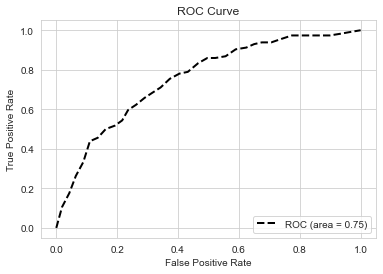

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_validation, y_vpred, pos_label=1)
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [101]:
def getReward(regressor, reward, threshold, Xs, ys, clicks):
    total_reward = 0
    for index,X in enumerate(Xs):
        if regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 1 and clicks[index] == True:
            total_reward += reward
        elif regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 0 and clicks[index] == True:
            total_reward += -10
    return total_reward

def getROI(reward, threshold, y_preds, ys, clicks):
    stack1 = np.stack([ys, y_preds])
    stack  = np.concatenate((stack1, [clicks]),axis=0)
    stack = stack.T
    
    gain_index = np.logical_and(stack[:,0] == 1,stack[:,1]> threshold)
    gain_stack = stack[gain_index,:]
    gain = len(gain_stack)*reward
    cost_index = np.logical_and(stack[:,2] == True,stack[:,1]> threshold)
    cost_stack = stack[cost_index,:]
    cost = len(cost_stack)*10
    return (gain-cost+len(gain_stack)*10)/(cost+0.001), len(gain_stack), gain-cost+len(gain_stack)*10
    
    
    
            

In [172]:
reward_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,130]
reward_buffers = {}
nSold_buffers = {}
gain_buffers = {}
thresholds = np.arange(0, 0.3, 0.005).tolist() +  np.arange(0.3, 1.9, 0.8).tolist()

for reward in reward_list:
    reward_buffers[reward]=[]
    nSold_buffers[reward] = []
    gain_buffers[reward] = []
    buffer_reward = []
    buffer_sold = []
    buffer_gain = []
    for threshold in thresholds:
        ROI, nSold, gain = getROI(reward,threshold, y_vpred, y_validation, click_validation)
        buffer_reward.append(ROI)
        buffer_sold.append(nSold)
        buffer_gain.append(gain)
    reward_buffers[reward]=buffer_reward
    nSold_buffers[reward]=buffer_sold
    gain_buffers[reward]=buffer_gain
        



<Figure size 432x288 with 0 Axes>

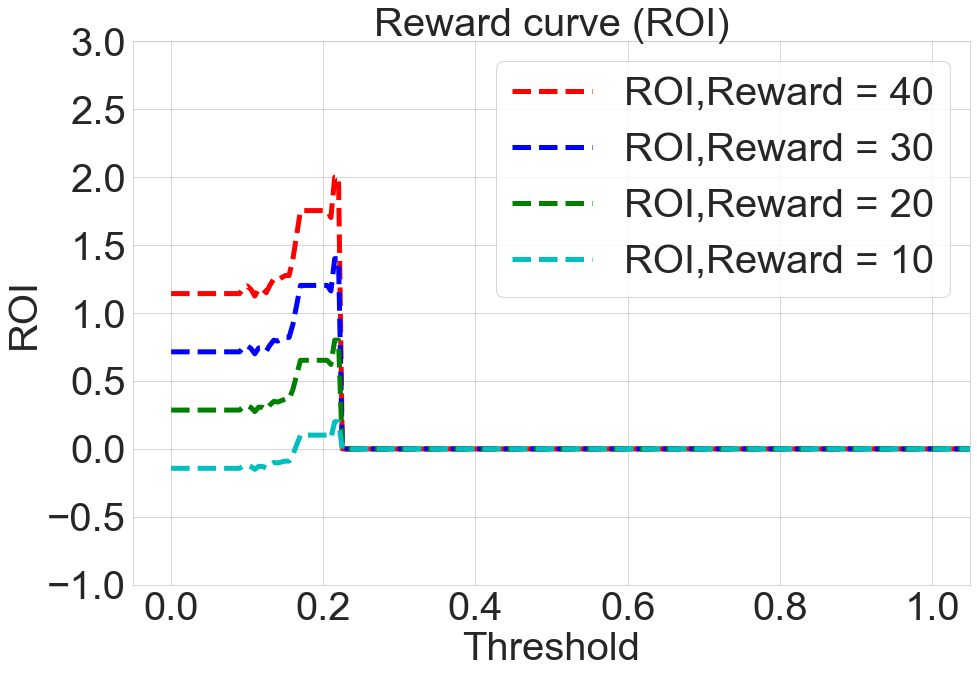

In [174]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, reward_buffers[40], 'r--',lw=5, label = "ROI,Reward = 40")
plt.plot(thresholds, reward_buffers[30], 'b--',lw=5, label = "ROI,Reward = 30")
plt.plot(thresholds, reward_buffers[20], 'g--',lw=5, label = "ROI,Reward = 20")
plt.plot(thresholds, reward_buffers[10], 'c--',lw=5, label = "ROI,Reward = 10")
 
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=40)
plt.ylim([-1.0, 3.0])
plt.yticks(fontsize=40)
plt.xlabel('Threshold',fontsize=40)
plt.ylabel('ROI', fontsize=40)
plt.title('Reward curve (ROI)', fontsize=40)
plt.legend(loc="upper right",prop={'size': 40})
plt.show()

<Figure size 432x288 with 0 Axes>

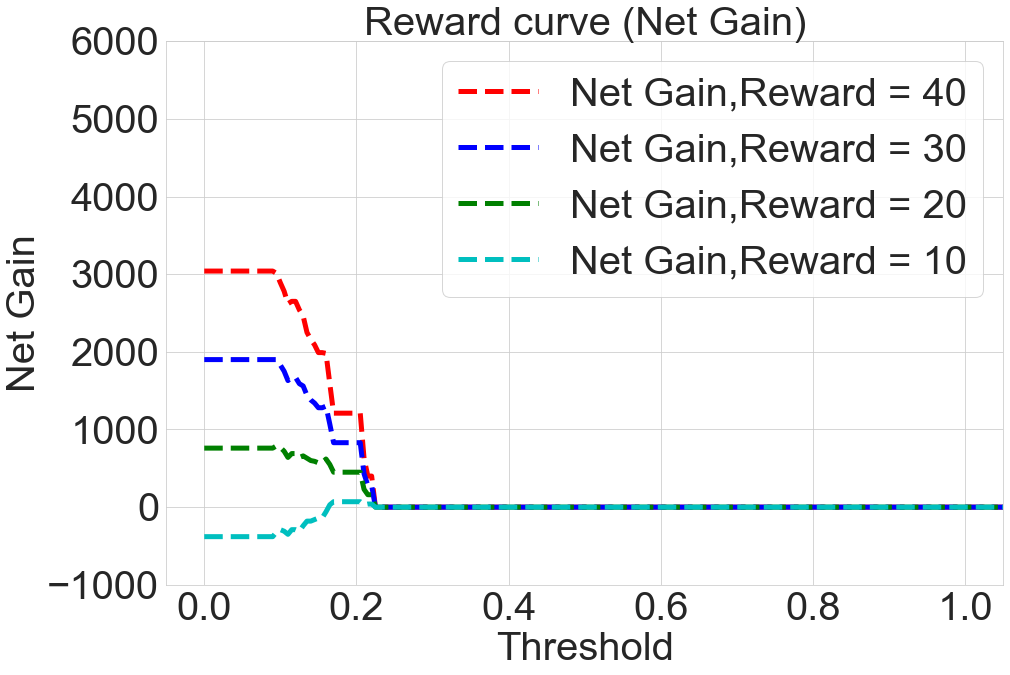

In [175]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, gain_buffers[40], 'r--',lw=5, label = "Net Gain,Reward = 40")
plt.plot(thresholds, gain_buffers[30], 'b--',lw=5, label = "Net Gain,Reward = 30")
plt.plot(thresholds, gain_buffers[20], 'g--',lw=5, label = "Net Gain,Reward = 20")
plt.plot(thresholds, gain_buffers[10], 'c--',lw=5, label = "Net Gain,Reward = 10")
 
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=40)
plt.ylim([-1000.0, 6000.0])
plt.yticks(fontsize=40)
plt.xlabel('Threshold',fontsize=40)
plt.ylabel('Net Gain',fontsize=40)
plt.title('Reward curve (Net Gain)',fontsize=40)
plt.legend(loc="upper right",prop={'size': 40})
plt.show()

<Figure size 432x288 with 0 Axes>

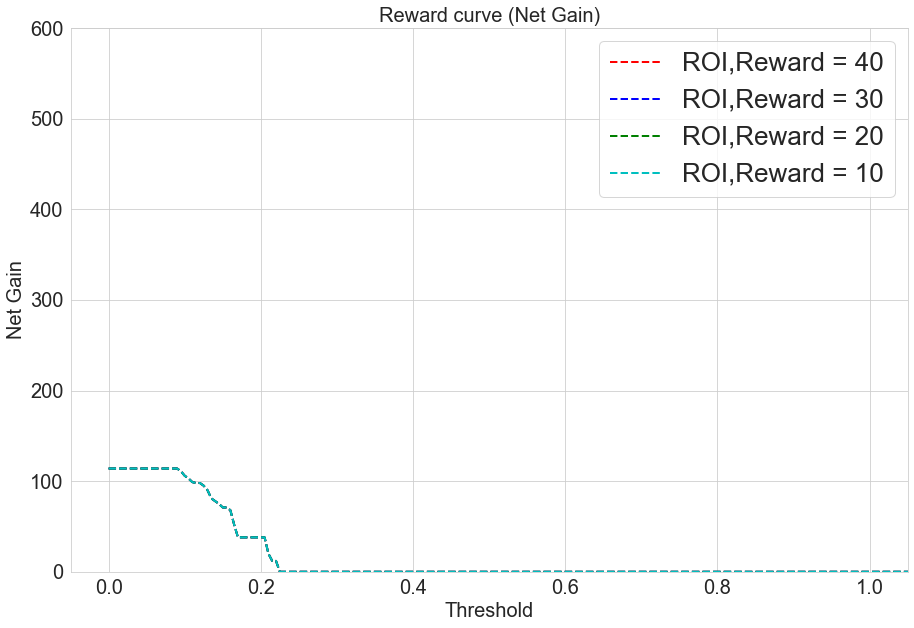

In [176]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(thresholds, nSold_buffers[40], 'r--',lw=2, label = "ROI,Reward = 40")
plt.plot(thresholds, nSold_buffers[30], 'b--',lw=2, label = "ROI,Reward = 30")
plt.plot(thresholds, nSold_buffers[20], 'g--',lw=2, label = "ROI,Reward = 20")
plt.plot(thresholds, nSold_buffers[10], 'c--',lw=2, label = "ROI,Reward = 10")
 
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=20)
plt.ylim([-0.0, 600.0])
plt.yticks(fontsize=20)
plt.xlabel('Threshold',fontsize=20)
plt.ylabel('Net Gain',fontsize=20)
plt.title('Reward curve (Net Gain)',fontsize=20)
plt.legend(loc="upper right",prop={'size': 26})
plt.show()

In [98]:
i_best_threshold = reward_buffer.index(max(reward_buffer))
best_threshold  = thresholds[i_best_threshold]
print("best_threshold = {}".format(best_threshold))

best_threshold = 0.1337425857782364


In [99]:
reward = getReward(clf,best_threshold,X_test,y_test,click_test)
print("reward = {}".format(reward))
reward_naive = getReward(clf,0,X_test,y_test,click_test)
print("naive reward = {}".format(reward_naive))

reward = 16660
naive reward = 5320


In [164]:
y_pred = clf.predict(X_test)

ROI, sold, netgain = getROI(140, 0, y_pred, y_test, click_test)
for threshold in np.arange(0, 0.3, 0.025).tolist():
    ROI_new, sold_new, netgain_new = getROI(140, threshold, y_pred, y_test, click_test)
    print("Threshold:{}  ROI:{} Sold:{} NetGain:{}".format(threshold,ROI_new/(ROI+0.001)-1,sold_new/(sold+0.001)-1,netgain_new/(netgain+0.001)-1))


Threshold:0.0  ROI:-0.00018775690459593708 Sold:-3.4722101658335447e-06 NetGain:-2.7495187460147008e-08
Threshold:0.025  ROI:-0.00018775690459593708 Sold:-3.4722101658335447e-06 NetGain:-2.7495187460147008e-08
Threshold:0.05  ROI:-0.00018775690459593708 Sold:-3.4722101658335447e-06 NetGain:-2.7495187460147008e-08
Threshold:0.07500000000000001  ROI:-0.00018775690459593708 Sold:-3.4722101658335447e-06 NetGain:-2.7495187460147008e-08
Threshold:0.1  ROI:0.04554808220279383 Sold:-0.0694476755289043 NetGain:-0.06296400706725291
Threshold:0.125  ROI:0.08010313976568839 Sold:-0.12153082801795823 NetGain:-0.11108058534284881
Threshold:0.15000000000000002  ROI:0.05517437578415518 Sold:-0.3993076412929121 NetGain:-0.39428101747921307
Threshold:0.17500000000000002  ROI:0.1951225752886976 Sold:-0.7152787663931722 NetGain:-0.7077261559602377
Threshold:0.2  ROI:0.1951225752886976 Sold:-0.7152787663931722 NetGain:-0.7077261559602377
Threshold:0.225  ROI:-1.0 Sold:-1.0 NetGain:-1.0
Threshold:0.25  ROI: